<a href="https://githubtocolab.com/geonextgis/cropengine/blob/main/docs/examples/Run wofost (multiple location).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [cropengine](https://geonextgis.github.io/cropengine) if needed.

In [ ]:
# !pip install -U cropengine

## Import libraries

In [ ]:
import os
import pandas as pd
import seaborn as sns
from cropengine import WOFOSTCropSimulationBatchRunner
from cropengine.agromanagement import WOFOSTAgroEventBuilder

## Instantiate batch crop simulation engine for WOFOST

In [ ]:
# Define the model name
MODEL_NAME = "Wofost72_WLP_CWB"

# Define the csv path with 'id', 'latitude', and 'longitude'
locations_csv_path = 'test_data/batch_run/location.csv'

# Initialize Engine
batch_runner = WOFOSTCropSimulationBatchRunner(model_name=MODEL_NAME, locations_csv_path=locations_csv_path, workspace_dir='batch_workspace')

## User inputs

In [ ]:
# Crop Configuration
# Note: Use dashboard.get_..._options() to see valid values if unsure
models = batch_runner.get_model_options()

crops = batch_runner.get_crop_options(MODEL_NAME)
CROP_NAME = "sugarbeet"
varieties = batch_runner.get_variety_options(MODEL_NAME, CROP_NAME)
CROP_VARIETY = "Sugarbeet_601"

# Timing
crop_start_end = batch_runner.get_crop_start_end_options()
CAMPAIGN_START = "2006-01-01"
CROP_START = "2006-04-05"
CROP_START_TYPE = "emergence"
CROP_END_TYPE = "harvest"
CROP_END = "2006-10-20"
CAMPAIGN_END = "2007-01-01"
MAX_DURATION = 300

## Create agromanagements with user inputs

In [ ]:
agro_event_builder = WOFOSTAgroEventBuilder()

# Note: Use agro_event_builder.get_..._events_info() to see valid values if unsure
timed_events_info = agro_event_builder.get_timed_events_info()
state_events_info = agro_event_builder.get_state_events_info()

# Build timed events (irrigation)
irrigation_schedule = [
    {"event_date": "2006-05-25", "amount": 3.0, "efficiency": 0.7},
    {"event_date": "2006-06-30", "amount": 2.5, "efficiency": 0.7},
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type="irrigate", events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {"threshold": 0.3, "N_amount": 40, "N_recovery": 0.7},
    {"threshold": 0.6, "N_amount": 60, "N_recovery": 0.7},
    {"threshold": 1.12, "N_amount": 40, "N_recovery": 0.7},
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type="apply_n",
    state_var="DVS",
    zero_condition="rising",
    events_list=nitrogen_schedule,
)

## Prepare batch system (must be implemented before running the batch simulation)

In [ ]:
batch_runner.prepare_batch_system(
    campaign_start=CAMPAIGN_START,
    campaign_end=CAMPAIGN_END,
    crop_start=CROP_START,
    crop_start_type=CROP_START_TYPE,
    crop_end_type=CROP_END_TYPE,
    crop_end=CROP_END,
    max_duration=MAX_DURATION,
    crop_name=CROP_NAME,
    variety_name=CROP_VARIETY,
    timed_events=[irrigation_events],
    state_events=[nitrogen_events],
    force_update=False,
    WAV=10  # Extra site params can be passed as a kwargs
)

[BATCH PREP] Preparing tasks for 3 locations...
[BATCH PREP] Starting preparation with 4 workers...


Preparing Data:   0%|          | 0/3 [00:00<?, ?it/s]

Preparing Data: 100%|██████████| 3/3 [00:13<00:00,  4.42s/it]

[BATCH PREP] Completed. 3/3 locations ready.


## Run the simulation

In [16]:
results = batch_runner.run_batch_simulation(max_workers=3)
print(results.shape)
results.head()

[BATCH RUN] Preparing execution tasks for 3 locations...
[BATCH RUN] Starting simulation with 3 workers...


Simulating: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

[BATCH RUN] Success! Results saved to c:\HALDER\GITHUB\LEARNING\cropengine\docs\examples\batch_workspace\batch_results.csv
(1098, 16)


,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA,point_id,latitude,longitude
0,2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40000,22.000000,NaN,1,53.3721,13.82299
1,2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31555,22.154351,NaN,1,53.3721,13.82299
2,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30077,22.162051,NaN,1,53.3721,13.82299
3,2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31455,22.307551,NaN,1,53.3721,13.82299
4,2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30721,22.379651,NaN,1,53.3721,13.82299


## Plot the batch results

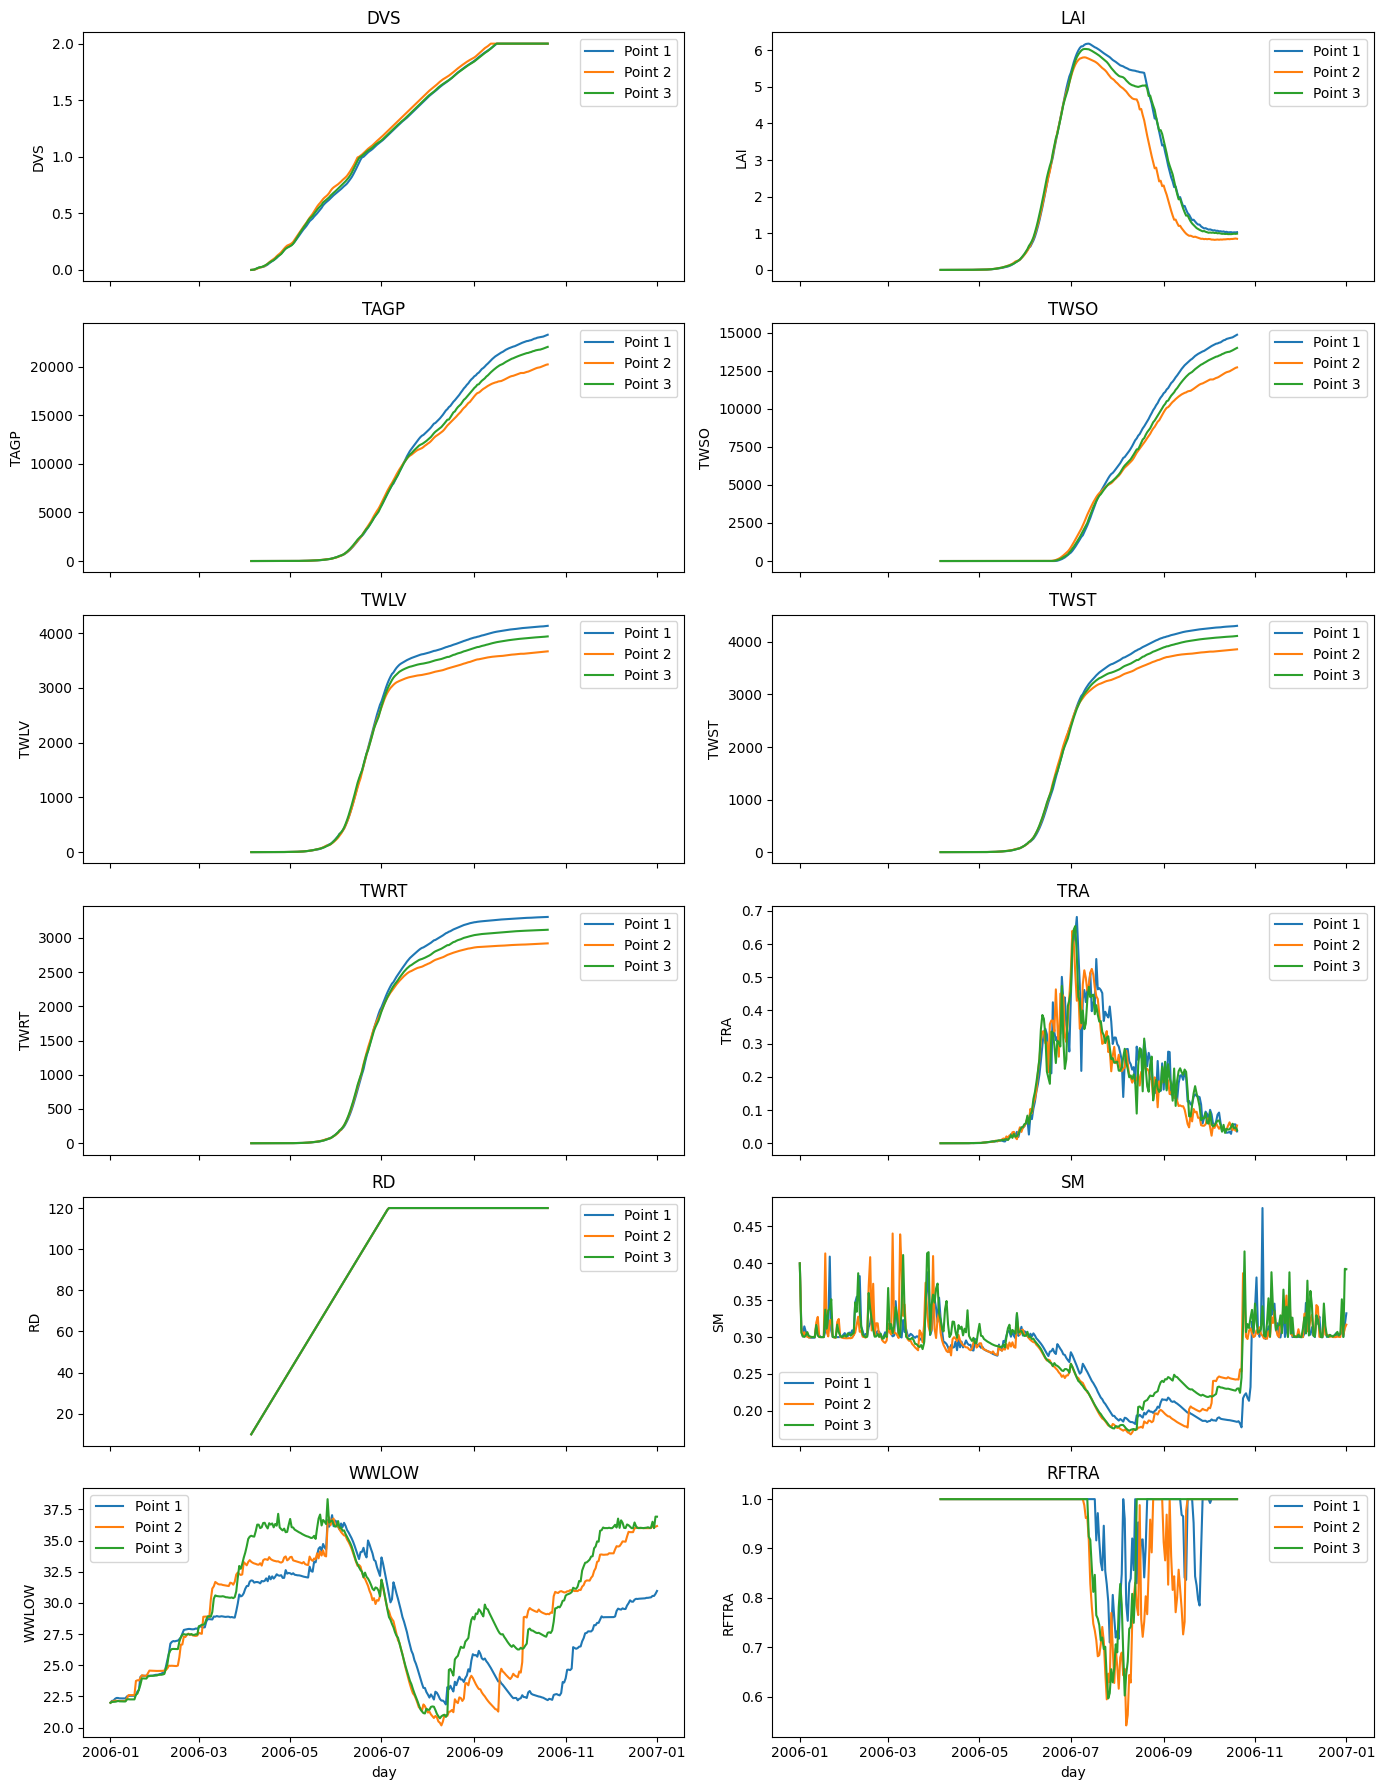

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Ensure 'day' is datetime
batch_results = results.copy()
batch_results['day'] = pd.to_datetime(batch_results['day'])

# Variables to plot (exclude metadata columns)
vars_to_plot = [
    col for col in batch_results.columns 
    if col not in ['point_id', 'latitude', 'longitude', 'day']
]

# Layout
cols = 2
rows = math.ceil(len(vars_to_plot) / cols)

# Colors for point_id groups
unique_points = batch_results['point_id'].unique()
palette = sns.color_palette("tab10", len(unique_points))
color_map = {pid: palette[i] for i, pid in enumerate(unique_points)}

fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), sharex=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    for pid in unique_points:
        df_sub = batch_results[batch_results['point_id'] == pid]

        sns.lineplot(
            x=df_sub['day'],
            y=df_sub[var],
            ax=ax,
            label=f'Point {pid}',
            color=color_map[pid]
        )

    ax.set_title(var)
    ax.legend()

# Hide remaining empty subplots
for j in range(len(vars_to_plot), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()